In [1]:
%%capture
# special workspace command


!pip install pmdarima

In [20]:
import os
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pmdarima as pm

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

# Load and merge necessary data

In [3]:
FOLDER = '/kaggle/input/test-assigment-smart-it/' # change to your folder path with tables

order_items = pd.read_csv(FOLDER + 'order_items.csv')
orders = pd.read_csv(FOLDER + 'orders.csv')
products = pd.read_csv(FOLDER + 'products.csv')

In [4]:
order_items = pd.merge(order_items, products[['product_id', 'product_category_name']], on='product_id')
order_items = pd.merge(order_items, orders[['order_id', 'order_purchase_timestamp']], on='order_id')
order_items['order_purchase_timestamp'] = pd.to_datetime(order_items['order_purchase_timestamp']).dt.date

order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,order_purchase_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,2017-09-13
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,2017-04-26
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,2018-01-14
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,2018-08-08
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,2017-02-04


# Function for obtain data by size of purchases during a day

In [5]:
def make_one_day_df(data, category):
    grouped_purchases_by_day = pd.DataFrame(data[
        data['product_category_name'] == category].groupby('order_purchase_timestamp').size())
    
    begin_date = data['order_purchase_timestamp'].min()
    end_date = data['order_purchase_timestamp'].max()
    date_range = pd.date_range(begin_date, end=end_date)
    
    df = pd.DataFrame({'order_purchase_timestamp': date_range, 'purchasing_count': 0})
    df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp']).dt.date
    df = df.set_index('order_purchase_timestamp')
    
    for i, r in df.iterrows():
        day_purchases = 0
        try:
            day_purchases = grouped_purchases_by_day.loc[i, 0]
        except KeyError as e:
            pass
        
        df.at[i, 'purchasing_count'] = day_purchases
        
    return df

In [6]:
day_df = make_one_day_df(order_items, category='esporte_lazer')
day_df.tail(10)

,purchasing_count
order_purchase_timestamp,
2018-08-25,2
2018-08-26,6
2018-08-27,12
2018-08-28,3
2018-08-29,1
2018-08-30,0
2018-08-31,0
2018-09-01,0
2018-09-02,0


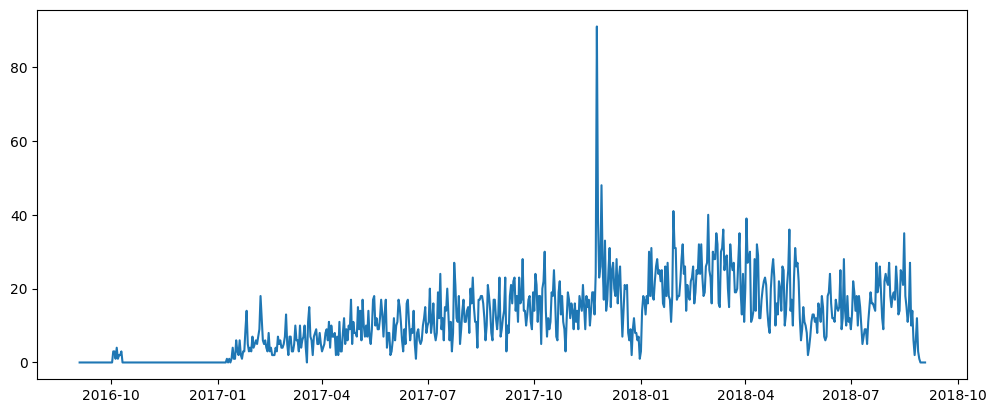

In [7]:
fig, ax = plt.subplots()

ax.plot(day_df.index, day_df['purchasing_count'])
fig.set_figwidth(12)

plt.show()

# Prepare data

In [8]:
PREDICT_DAYS = 14
AFTER_DAYS = 7

OVERALL_DAYS = AFTER_DAYS + PREDICT_DAYS

In [9]:
data_df = make_one_day_df(order_items, category='esporte_lazer')

full_data = data_df['purchasing_count'].values
train = full_data[:-OVERALL_DAYS]
test = full_data[-OVERALL_DAYS:]

len(train), len(test)

(709, 21)

# Machine learning approach

Task is to predict 14 days after 7 days of last date. For each model I will be predicting 21 days and highlight 8-21th days in visualization.
<br><br>
I will transform historic data for machine learning and use orginal data history for stistical model.
<br>
Transformed data is made with rolling window technique.
<br><br>
XGBoost regressor I chose because its usually more accurate.
<br>
Auto ARIMA because its auto. Data have different categories so model can fit better for each one by itself than use one general.

In [78]:
def transform_data(data, shift=6, dropnan=True, fillna=False):
    df = pd.DataFrame(data)
    cols = []
    
    for i in range(shift, 0, -1): 
        cols.append(df.shift(i)) 
    
    agg = pd.concat(cols, axis=1)
    
    if dropnan:
        agg.dropna(inplace=True) 
    if fillna:
        agg.fillna(0, inplace=True)
    
    return agg.values


def create_fit_model(train):
    train = np.asarray(train)
    
    train_X, train_y = train[:, :-1], train[:, -1]
    
    model = XGBRegressor(n_estimators=150, max_depth=3, subsample=0.5, colsample_bytree=0.5)
#     model = RandomForestRegressor(n_estimators=100)
    model.fit(train_X, train_y)
    
    return model


def continuous_prediction(data, future_days):
    model = create_fit_model(data)
    history = [list(arr) for arr in data]
    
    for i in range(future_days):
        last_shift = history[-1][1:]
        
        predicted_day = model.predict([last_shift])[0]
        
        last_shift.append(predicted_day)
        history.append(last_shift)
    
    predictions = history[-1][-future_days:]
    return predictions

## Test prediction

In [79]:
train_transformed = transform_data(train, shift=28*6, dropnan=False, fillna=True)

test_predictions = continuous_prediction(train_transformed, future_days=OVERALL_DAYS)

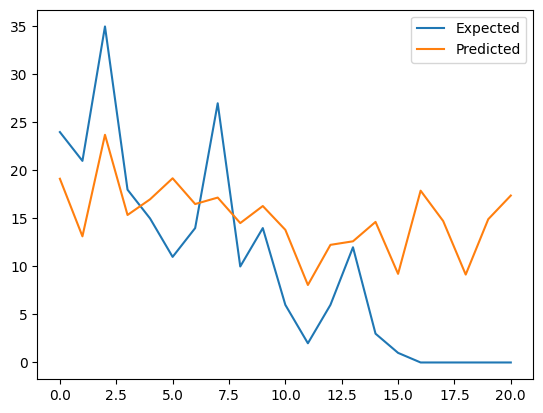

In [80]:
plt.plot(test, label='Expected')
plt.plot(test_predictions, label='Predicted')
plt.legend()
plt.show()

## Future prediction

In [81]:
all_data_transformed = transform_data(full_data, shift=28*6, dropnan=False, fillna=True)

future_predictions = continuous_prediction(all_data_transformed, OVERALL_DAYS)

print(f'Number of predicted days after last date: {len(future_predictions)}')

Number of predicted days after last date: 21


# Visualize

In [76]:
def plot_history_test_forecast(history_df, test_predictions, future_predictions, zoom_last=None):
    test_time = pd.date_range(
        history_df.index.max() - datetime.timedelta(days=len(test_predictions)),
        history_df.index.max()
    )[1:]
    test_df = pd.DataFrame(index=test_time, data=test_predictions)
    
    future_time = pd.date_range(
        history_df.index.max() + datetime.timedelta(days=AFTER_DAYS),
        history_df.index.max() + datetime.timedelta(days=len(future_predictions))
    )[1:]
    future_df = pd.DataFrame(index=future_time, data=future_predictions[AFTER_DAYS:])

    
    f = plt.figure()
    f.set_figwidth(12)
    f.set_figheight(5)
    
    plt.plot(history_df, label='Previous')
    plt.plot(test_df, label='Test')
    plt.plot(future_df, label='Future')
    
    if zoom_last is not None:
        max_date = future_time.max()
        shift_back = max_date - datetime.timedelta(days=zoom_last)
        plt.xlim((shift_back, max_date))
        
        max_value = max([future_df.values.max(), test_df.values.max(), history_df[-zoom_last:].values.max()]) + 1
        plt.ylim((-1, max_value))
    
    plt.legend()
    plt.show()

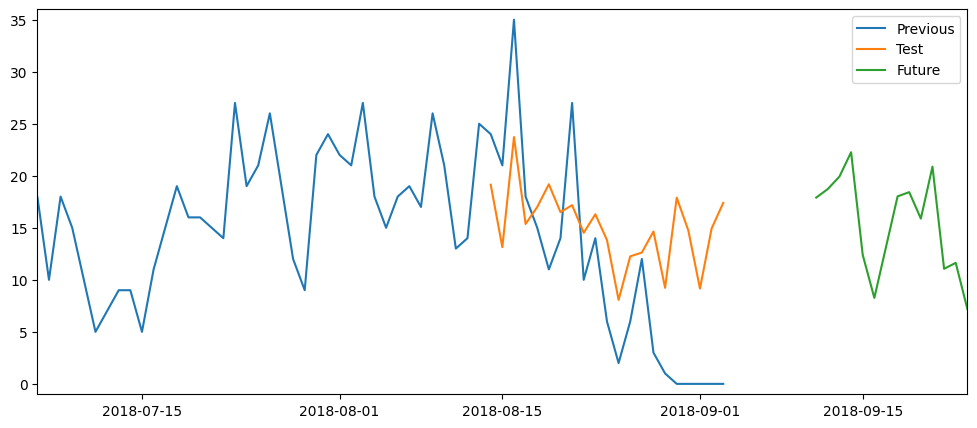

In [82]:
plot_history_test_forecast(data_df, test_predictions, future_predictions, zoom_last=80)

# Classic statistic model. ARIMA

In [83]:
def arima_predict(data_arr, n_periods, max_p=4, max_q=4):
    arima = pm.auto_arima(
        data_arr,
        start_p=0, start_q=0,
        max_p=max_p, max_q=max_q,
        m=48,             # frequency of series
        test='adf',       # use adftest to find optimal 'd'
        d=None,           # let model determine 'd'
        seasonal=True,    
        start_P=0, 
        D=1,
        trace=True,
        error_action='ignore',  
        suppress_warnings=True, 
        stepwise=True,
    )

    # print(arima.summary())
    return arima.predict(n_periods=n_periods)

In [84]:
test_predictions_arima = arima_predict(train, OVERALL_DAYS, 1, 1)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[48] intercept   : AIC=inf, Time=20.46 sec
 ARIMA(0,0,0)(0,1,0)[48] intercept   : AIC=4774.571, Time=0.54 sec
 ARIMA(1,0,0)(1,1,0)[48] intercept   : AIC=4559.780, Time=15.48 sec
 ARIMA(0,0,1)(0,1,1)[48] intercept   : AIC=inf, Time=31.32 sec
 ARIMA(0,0,0)(0,1,0)[48]             : AIC=4783.320, Time=0.34 sec
 ARIMA(1,0,0)(0,1,0)[48] intercept   : AIC=4702.000, Time=3.35 sec
 ARIMA(1,0,0)(2,1,0)[48] intercept   : AIC=4517.506, Time=48.17 sec
 ARIMA(1,0,0)(2,1,1)[48] intercept   : AIC=inf, Time=151.71 sec
 ARIMA(1,0,0)(1,1,1)[48] intercept   : AIC=inf, Time=46.81 sec
 ARIMA(0,0,0)(2,1,0)[48] intercept   : AIC=4654.711, Time=35.76 sec
 ARIMA(1,0,1)(2,1,0)[48] intercept   : AIC=4494.944, Time=90.73 sec
 ARIMA(1,0,1)(1,1,0)[48] intercept   : AIC=4538.456, Time=31.12 sec
 ARIMA(1,0,1)(2,1,1)[48] intercept   : AIC=inf, Time=197.37 sec
 ARIMA(1,0,1)(1,1,1)[48] intercept   : AIC=inf, Time=70.65 sec
 ARIMA(0,0,1)(2,1,0)[48] intercept  

In [88]:
print('\n'.join([
    'Compare MAE - mean absolute error (lower is better) score on Test data with:',
    f'XGBRegressor: {mean_absolute_error(test, test_predictions):.2f}',
    f'ARIMA: {mean_absolute_error(test, test_predictions_arima):.2f}',
]))

Compare MAE - mean absolute error (lower is better) score on Test data with:
XGBRegressor: 8.13
ARIMA: 9.36


In [87]:
future_predictions_arima = arima_predict(full_data, OVERALL_DAYS, 1, 1)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[48] intercept   : AIC=4792.556, Time=7.66 sec
 ARIMA(0,0,0)(0,1,0)[48] intercept   : AIC=4930.960, Time=0.50 sec
 ARIMA(1,0,0)(1,1,0)[48] intercept   : AIC=4710.982, Time=15.93 sec
 ARIMA(0,0,1)(0,1,1)[48] intercept   : AIC=inf, Time=18.50 sec
 ARIMA(0,0,0)(0,1,0)[48]             : AIC=4938.226, Time=0.34 sec
 ARIMA(1,0,0)(0,1,0)[48] intercept   : AIC=4852.082, Time=3.45 sec
 ARIMA(1,0,0)(2,1,0)[48] intercept   : AIC=4672.271, Time=52.61 sec
 ARIMA(1,0,0)(2,1,1)[48] intercept   : AIC=inf, Time=142.07 sec
 ARIMA(1,0,0)(1,1,1)[48] intercept   : AIC=inf, Time=42.79 sec
 ARIMA(0,0,0)(2,1,0)[48] intercept   : AIC=4820.882, Time=41.47 sec
 ARIMA(1,0,1)(2,1,0)[48] intercept   : AIC=4648.587, Time=91.92 sec
 ARIMA(1,0,1)(1,1,0)[48] intercept   : AIC=4689.301, Time=29.83 sec
 ARIMA(1,0,1)(2,1,1)[48] intercept   : AIC=inf, Time=202.67 sec
 ARIMA(1,0,1)(1,1,1)[48] intercept   : AIC=inf, Time=65.02 sec
 ARIMA(0,0,1)(2,1,0)[48] interce

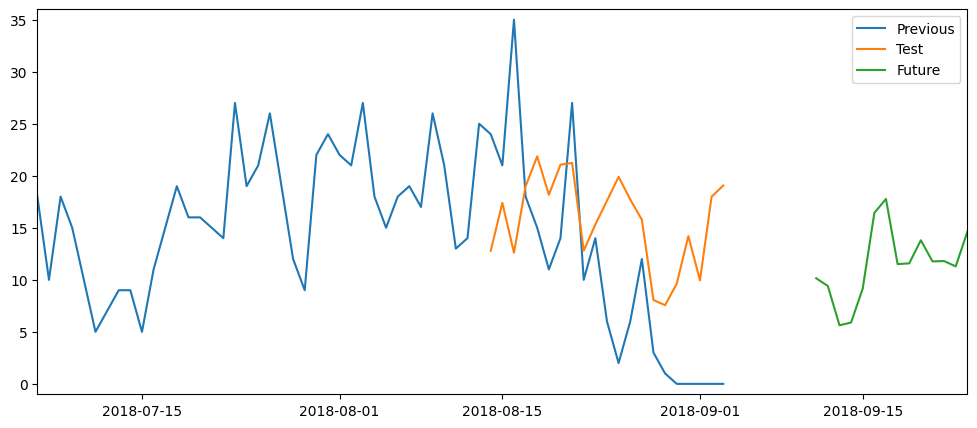

In [89]:
plot_history_test_forecast(data_df, test_predictions_arima, future_predictions_arima, zoom_last=80)